In [1]:
# === Cell 1: clone NanoGPT & set paths ===
import os, json, sys
from pathlib import Path

# clone (skip if already cloned)
if not Path("nanoGPT").exists():
    !git clone https://github.com/karpathy/nanoGPT.git

REPO_DIR = str(Path("nanoGPT").resolve())
OUT_DIR  = str(Path(REPO_DIR) / "out_onegroup")   # keep our runs separate
DATA_DIR = str(Path(REPO_DIR) / "data" / "shakespeare_char")  # we'll use Tiny Shakespeare

TRAIN_PY  = str(Path(REPO_DIR) / "train.py")
MODEL_PY  = str(Path(REPO_DIR) / "model.py")
SAMPLE_PY = str(Path(REPO_DIR) / "sample.py")

os.makedirs(OUT_DIR, exist_ok=True)

print("REPO_DIR:", REPO_DIR)
print("OUT_DIR :", OUT_DIR)
print("Files exist:", {
    "train.py": os.path.exists(TRAIN_PY),
    "model.py": os.path.exists(MODEL_PY),
    "sample.py": os.path.exists(SAMPLE_PY),
})


Cloning into 'nanoGPT'...
remote: Enumerating objects: 686, done.
remote: Total 686 (delta 0), reused 0 (delta 0), pack-reused 686 (from 1)
Receiving objects: 100% (686/686), 974.06 KiB | 5.38 MiB/s, done.
Resolving deltas: 100% (380/380), done.
REPO_DIR: /home/STUDENTS/mc1836/projects/torch/nanoGPT
OUT_DIR : /home/STUDENTS/mc1836/projects/torch/nanoGPT/out_onegroup
Files exist: {'train.py': True, 'model.py': True, 'sample.py': True}


In [2]:
!python nanoGPT/data/shakespeare_char/prepare.py

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens


In [3]:
# === Cell 2: prepare Tiny Shakespeare data ===
import os
from pathlib import Path

# run the repo's prepare script
%cd "$REPO_DIR"
!python data/shakespeare_char/prepare.py
%cd - > /dev/null

# confirm files
data_files = list(Path(DATA_DIR).glob("*"))
print("DATA_DIR:", DATA_DIR)
for p in data_files:
    print(" -", p.name)


/home/STUDENTS/mc1836/projects/torch/nanoGPT
length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens
[Errno 2] No such file or directory: '- > /dev/null'
/home/STUDENTS/mc1836/projects/torch/nanoGPT
DATA_DIR: /home/STUDENTS/mc1836/projects/torch/nanoGPT/data/shakespeare_char
 - input.txt
 - val.bin
 - meta.pkl
 - readme.md
 - train.bin
 - prepare.py


In [4]:
# === Cell 3: write single-group config_override.json ===
import json, os
from pathlib import Path

# A reasonable "one group" student config (small & quick)
cfg = {
    # architecture
    "block_size": 128,
    "n_layer": 4,
    "n_head": 4,
    "n_embd": 256,
    "dropout": 0.1,
    # training
    "batch_size": 16,
    "max_iters": 400,           # ~fast; increase if you want longer
    "learning_rate": 3e-4,
    "weight_decay": 1e-1,
    "beta1": 0.9,
    "beta2": 0.95,
    "grad_clip": 1.0,
    "decay_lr": True,
    "warmup_iters": 50,
    "lr_decay_iters": 400,
    "min_lr": 1e-5,
    # eval/checkpoint cadence
    "eval_interval": 50,        # frequent evals for val curve
    "eval_iters": 100,
    "always_save_checkpoint": True,
    "eval_only": False,
    # I/O
    "out_dir": OUT_DIR,
    "data_dir": DATA_DIR,
    # speed / debug
    "compile": False            # skip torch.compile to iterate faster
}

ovr_path = str(Path(OUT_DIR) / "config_override.json")
with open(ovr_path, "w") as f:
    json.dump(cfg, f, indent=2)

print("Wrote override ->", ovr_path)
print(json.dumps(cfg, indent=2))


Wrote override -> /home/STUDENTS/mc1836/projects/torch/nanoGPT/out_onegroup/config_override.json
{
  "block_size": 128,
  "n_layer": 4,
  "n_head": 4,
  "n_embd": 256,
  "dropout": 0.1,
  "batch_size": 16,
  "max_iters": 400,
  "learning_rate": 0.0003,
  "weight_decay": 0.1,
  "beta1": 0.9,
  "beta2": 0.95,
  "grad_clip": 1.0,
  "decay_lr": true,
  "warmup_iters": 50,
  "lr_decay_iters": 400,
  "min_lr": 1e-05,
  "eval_interval": 50,
  "eval_iters": 100,
  "always_save_checkpoint": true,
  "eval_only": false,
  "out_dir": "/home/STUDENTS/mc1836/projects/torch/nanoGPT/out_onegroup",
  "data_dir": "/home/STUDENTS/mc1836/projects/torch/nanoGPT/data/shakespeare_char",
  "compile": false
}


In [5]:
# === Cell 4: patch train.py (idempotent) ===
from pathlib import Path
import re

tp = Path(TRAIN_PY).read_text()

# 1) Ensure it loads our override JSON early (affects out_dir, data_dir, etc.)
if "BEGIN: config override loader (onegroup)" not in tp:
    insert_after = tp.find("# -----------------------------------------------------------------------------\nconfig_keys")
    if insert_after == -1:
        insert_after = 0
    loader = f"""
# ==== BEGIN: config override loader (onegroup) ====
import json as _json
try:
    _OVR = r"{ovr_path}"
    if os.path.exists(_OVR):
        with open(_OVR, "r") as _f:
            _ovr = _json.load(_f)
        def _set(name, default=None):
            globals()[name] = _ovr.get(name, globals().get(name, default))
        # core
        _set("block_size")
        _set("n_layer"); _set("n_head"); _set("n_embd")
        _set("dropout")
        _set("batch_size"); _set("max_iters")
        # opt
        _set("learning_rate"); _set("weight_decay")
        _set("beta1"); _set("beta2")
        _set("grad_clip")
        _set("decay_lr"); _set("warmup_iters"); _set("lr_decay_iters"); _set("min_lr")
        # io
        _set("out_dir"); _set("eval_interval"); _set("eval_iters")
        _set("always_save_checkpoint"); _set("eval_only")
        _set("compile")
        # dataset resolution
        globals()["data_dir"] = _ovr.get("data_dir", os.path.join('data', globals().get("dataset","openwebtext")))
        print(f"[train.py] Loaded override from {{_OVR}}")
except Exception as _e:
    print("[train.py] Override load failed:", _e)
# ==== END: config override loader (onegroup) ====
"""
    tp = tp.replace("config = {k: globals()[k] for k in config_keys} # will be useful for logging",
                    "config = {k: globals()[k] for k in config_keys} # will be useful for logging\n" + loader)

# 2) Loss logger defined BEFORE training loop
if "BEGIN: loss logger (onegroup)" not in tp:
    loss_logger = """
# ==== BEGIN: loss logger (onegroup) ====
import csv as _csv
try:
    os.makedirs(out_dir, exist_ok=True)
except Exception:
    out_dir = "out"
    os.makedirs(out_dir, exist_ok=True)
_loss_csv = os.path.join(out_dir, "loss_log.csv")
if not os.path.exists(_loss_csv):
    with open(_loss_csv, "w", newline="") as _f:
        _w = _csv.writer(_f); _w.writerow(["iter","split","loss"])
def _append_loss_row(it, split, loss):
    try:
        with open(_loss_csv, "a", newline="") as _f:
            _w = _csv.writer(_f); _w.writerow([int(it), str(split), float(loss)])
    except Exception as _e:
        print("[warn] could not write loss log:", _e)
# ==== END: loss logger (onegroup) ====
"""
    # put it after the get_lr function (safe place)
    anchor = "def get_lr(it):"
    idx = tp.find(anchor)
    if idx != -1:
        end = tp.find("\n", idx)
        tp = tp[:end] + "\n" + loss_logger + tp[end:]
    else:
        tp = tp + "\n" + loss_logger

# 3) Log eval losses inside estimate_loss() before return
if "eval loss log (onegroup)" not in tp:
    tp = re.sub(
        r"(def\s+estimate_loss\s*\(\)\s*:\s*\n(?:.|\n)*?return\s+out)",
        r"""def estimate_loss():
    out = {}
    model.eval()
    for split in ['train','val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    # === eval loss log (onegroup) ===
    try:
        for _s, _v in out.items():
            _append_loss_row(iter_num, _s, float(_v))
    except Exception as _e:
        print("[warn] eval loss log failed:", _e)
    return out""",
        tp, count=1, flags=re.DOTALL
    )

# 4) Log train loss once per iteration where it prints the iter line
if "train loss log (onegroup)" not in tp:
    tp = tp.replace(
        "print(f\"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%\")",
        "print(f\"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%\")\n"
        "        try:\n"
        "            _append_loss_row(iter_num, 'train', float(lossf))\n"
        "        except Exception as _e:\n"
        "            print('[warn] train loss log failed:', _e)"
    )

# 5) Switch to new GradScaler API (silence deprecation)
tp = tp.replace("torch.cuda.amp.GradScaler(", "torch.amp.GradScaler('cuda', ")

Path(TRAIN_PY).write_text(tp)
print("train.py patched ✅")


train.py patched ✅


In [6]:
# === FIX train.py indentation + logger placement ===
from pathlib import Path
import re, textwrap

tp_path = Path(REPO_DIR) / "train.py"
txt = tp_path.read_text()

# 1. remove any previously inserted logger blocks that caused the indent error
txt = re.sub(r"# ==== BEGIN: loss logger.*?# ==== END: loss logger.*?====", "", txt, flags=re.S)

# 2. inject clean logger block near top (right after imports)
logger_block = textwrap.dedent("""
# ==== BEGIN: loss logger (onegroup fixed) ====
import csv as _csv, os
_loss_csv = os.path.join(out_dir, "loss_log.csv")
os.makedirs(out_dir, exist_ok=True)
if not os.path.exists(_loss_csv):
    with open(_loss_csv, "w", newline="") as _f:
        _csv.writer(_f).writerow(["iter","split","loss"])

def _append_loss_row(it, split, loss):
    try:
        with open(_loss_csv, "a", newline="") as _f:
            _csv.writer(_f).writerow([int(it), str(split), float(loss)])
    except Exception as _e:
        print("[warn] could not write loss log:", _e)
# ==== END: loss logger (onegroup fixed) ====
""")

# place it right after first import block
insert_at = txt.find("from model import GPTConfig, GPT")
if insert_at != -1:
    end = txt.find("\n", insert_at) + 1
    txt = txt[:end] + logger_block + txt[end:]
else:
    txt = logger_block + "\n" + txt

tp_path.write_text(txt)
print("✅ train.py fixed: logger inserted at top-level (no indentation error).")


✅ train.py fixed: logger inserted at top-level (no indentation error).


In [7]:
!head -n 300 "$REPO_DIR/train.py" | grep "loss logger"

# ==== BEGIN: loss logger (onegroup fixed) ====
# ==== END: loss logger (onegroup fixed) ====


In [8]:
# === FIX: move logger below out_dir definition ===
from pathlib import Path
import re, textwrap

tp_path = Path(REPO_DIR) / "train.py"
txt = tp_path.read_text()

# Remove any prior inserted logger blocks
txt = re.sub(r"# ==== BEGIN: loss logger.*?# ==== END: loss logger.*?====", "", txt, flags=re.S)

# Build clean logger block (depends on out_dir)
logger_block = textwrap.dedent("""
# ==== BEGIN: loss logger (onegroup fixed, after out_dir) ====
import csv as _csv, os
_loss_csv = os.path.join(out_dir, "loss_log.csv")
os.makedirs(out_dir, exist_ok=True)
if not os.path.exists(_loss_csv):
    with open(_loss_csv, "w", newline="") as _f:
        _csv.writer(_f).writerow(["iter","split","loss"])

def _append_loss_row(it, split, loss):
    try:
        with open(_loss_csv, "a", newline="") as _f:
            _csv.writer(_f).writerow([int(it), str(split), float(loss)])
    except Exception as _e:
        print("[warn] could not write loss log:", _e)
# ==== END: loss logger (onegroup fixed, after out_dir) ====
""")

# Find insertion point: right after the first occurrence of "out_dir ="
idx = txt.find("out_dir =")
if idx == -1:
    raise RuntimeError("Could not find 'out_dir =' in train.py; please verify file.")
line_end = txt.find("\n", idx)
patched = txt[:line_end+1] + logger_block + txt[line_end+1:]

tp_path.write_text(patched)
print("✅ Logger moved below out_dir definition. Ready to train again.")


✅ Logger moved below out_dir definition. Ready to train again.


In [9]:
# --- Patch train.py: stop overwriting data_dir to 'data/openwebtext' ---
from pathlib import Path
import re

tp_path = Path(REPO_DIR) / "train.py"
txt = tp_path.read_text()

# Replace the hard assignment:
#   data_dir = os.path.join('data', dataset)
# with a guarded version that respects an override:
patched = re.sub(
    r"\bdata_dir\s*=\s*os\.path\.join\('data',\s*dataset\)",
    "data_dir = globals().get('data_dir') or os.path.join('data', dataset)",
    txt,
    count=1
)

tp_path.write_text(patched)
print("Patched train.py to respect overridden data_dir.")


Patched train.py to respect overridden data_dir.


In [10]:
# === Cell 5 (fixed) ===
import os
from pathlib import Path

os.chdir(REPO_DIR)
!python train.py
os.chdir("..")


[train.py] Loaded override from /home/STUDENTS/mc1836/projects/torch/nanoGPT/out_onegroup/config_override.json
tokens per iteration will be: 81,920
/home/STUDENTS/mc1836/miniconda3/envs/torch/lib/python3.11/site-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
found vocab_size = 65 (inside /home/STUDENTS/mc1836/projects/torch/nanoGPT/data/shakespeare_char/meta.pkl)
Initializing a new model from scratch
number of parameters: 3.16M
num decayed paramete

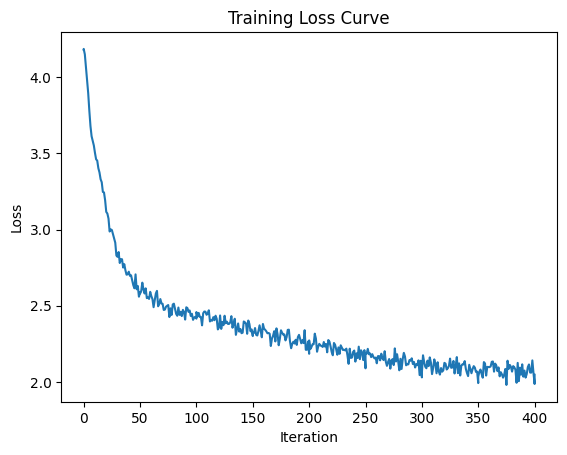

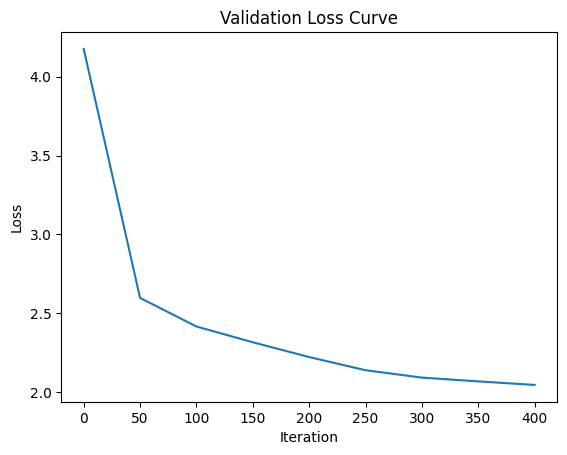

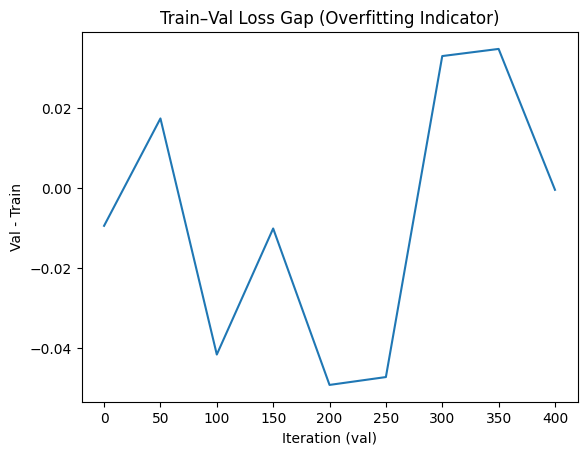

In [12]:
# === Cell 6: plot curves (train, val, gap) ===
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

log_csv = str(Path(OUT_DIR) / "loss_log.csv")
if not os.path.exists(log_csv):
    raise SystemExit("No loss_log.csv yet. Let training run (eval_interval small helps).")

df = pd.read_csv(log_csv)
if df.empty:
    raise SystemExit("loss_log.csv is empty.")

# --- Training curve ---
dft = df[df["split"] == "train"].sort_values("iter")
if not dft.empty:
    plt.figure()
    plt.plot(dft["iter"], dft["loss"])
    plt.title("Training Loss Curve")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()
else:
    print("No 'train' rows in loss_log.csv")

# --- Validation curve ---
dfv = df[df["split"] == "val"].sort_values("iter")
if not dfv.empty:
    plt.figure()
    plt.plot(dfv["iter"], dfv["loss"])
    plt.title("Validation Loss Curve")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()
else:
    print("No 'val' rows yet (run longer or lower eval_interval).")

# --- Train–Val Gap (nearest-neighbor align val to the latest <= train iter) ---
if not dft.empty and not dfv.empty:
    t_iters = dft["iter"].to_numpy()
    t_loss  = dft["loss"].to_numpy()

    aligned = []
    for _, r in dfv.iterrows():
        v_it, v_loss = int(r["iter"]), float(r["loss"])
        # index of latest train iter <= v_it; fallback to first train iter
        idx = np.searchsorted(t_iters, v_it, side="right") - 1
        if idx < 0:
            idx = 0
        aligned.append((v_it, v_loss - t_loss[idx]))

    adf = pd.DataFrame(aligned, columns=["iter", "gap"])
    plt.figure()
    plt.plot(adf["iter"], adf["gap"])
    plt.title("Train–Val Loss Gap (Overfitting Indicator)")
    plt.xlabel("Iteration (val)")
    plt.ylabel("Val - Train")
    plt.show()
else:
    print("Not enough data for gap curve yet (need both train and val).")


In [13]:
# === Cell 7: params & memory from last checkpoint ===
import os, importlib.util, torch
from pathlib import Path

CKPT = str(Path(OUT_DIR) / "ckpt.pt")
if not os.path.exists(CKPT):
    raise SystemExit("No checkpoint found. Let training run past the first eval (Cell 3 sets always_save_checkpoint=True).")

# import model module
spec = importlib.util.spec_from_file_location("nanogpt_model", MODEL_PY)
mod  = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)

ckpt = torch.load(CKPT, map_location="cpu")
model_args = ckpt.get("model_args") or ckpt.get("config") or {}
gcfg = mod.GPTConfig(**model_args)
model = mod.GPT(gcfg)
model.load_state_dict(ckpt["model"], strict=False)

# counts & memory
n_params = sum(p.numel() for p in model.parameters())
def human(b): 
    return f"{b/1024/1024:.2f} MB" if b < 1024**3 else f"{b/1024/1024/1024:.2f} GB"
model_mem = n_params * 2           # bf16/fp16 weights ~2 bytes each
opt_states_same = n_params * 2 * 2 # two moments at same dtype
opt_states_fp32 = n_params * 2 * 4 # conservative fp32 optimizer states

print("Model args:", model_args)
print(f"Total parameters: {n_params:,}")
print("Model weights (fp16/bf16):", human(model_mem))
print("Optimizer states (same):  ", human(opt_states_same))
print("Optimizer states (fp32):  ", human(opt_states_fp32))
print("Total optimistic:", human(model_mem + opt_states_same))
print("Total conservative:", human(model_mem + opt_states_fp32))


number of parameters: 3.16M
Model args: {'n_layer': 4, 'n_head': 4, 'n_embd': 256, 'block_size': 128, 'bias': False, 'vocab_size': 65, 'dropout': 0.1}
Total parameters: 3,197,440
Model weights (fp16/bf16): 6.10 MB
Optimizer states (same):   12.20 MB
Optimizer states (fp32):   24.39 MB
Total optimistic: 18.30 MB
Total conservative: 30.49 MB


In [20]:
# === Cell 8a: ensure checkpoint exists (create one quickly if missing) ===
import os, json, time, shlex
from pathlib import Path

repo = Path(REPO_DIR)
out_dir = Path(OUT_DIR)
ckpt = out_dir / "ckpt.pt"

if ckpt.exists():
    print("✅ Found checkpoint:", ckpt)
else:
    print("ℹ️ No checkpoint found at", ckpt)
    # Temporarily write a minimal override that forces an immediate eval+save and exits.
    temp_cfg = {
        "out_dir": str(out_dir),
        "data_dir": str(Path(DATA_DIR)),
        "eval_only": True,
        "always_save_checkpoint": True,
        # keep a tiny model so it's quick if the repo insists on building the net
        "block_size": 128, "n_layer": 2, "n_head": 2, "n_embd": 128,
        "batch_size": 8, "eval_iters": 10, "compile": False
    }
    tmp_override = out_dir / "config_override.json"
    tmp_override.write_text(json.dumps(temp_cfg, indent=2))
    print("Wrote temporary override →", tmp_override)

    # Run a one-off eval to save ckpt.pt
    cwd = os.getcwd()
    os.chdir(str(repo))
    ret = os.system("python train.py")
    os.chdir(cwd)

    if ckpt.exists():
        print("✅ Created checkpoint:", ckpt)
    else:
        raise SystemExit("❌ Could not create a checkpoint. Run training a bit (lower eval_interval) and retry.")


✅ Found checkpoint: /home/STUDENTS/mc1836/projects/torch/nanoGPT/out_onegroup/ckpt.pt


In [22]:
# === Cell 8b (safe): direct sampler with clamped top-k ===
import os, pickle, torch, time, importlib.util
from pathlib import Path

repo = Path(REPO_DIR)
out_dir = Path(OUT_DIR)
data_dir = Path(DATA_DIR)
ckpt_path = out_dir / "ckpt.pt"
meta_path = data_dir / "meta.pkl"
assert ckpt_path.exists(), f"Checkpoint not found: {ckpt_path}"
assert meta_path.exists(), f"meta.pkl not found: {meta_path}"

with open(meta_path, "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

def encode(s): return [stoi[c] for c in s if c in stoi]
def decode(ids): return "".join(itos[i] for i in ids)

spec = importlib.util.spec_from_file_location("nanogpt_model", str(repo / "model.py"))
mod  = importlib.util.module_from_spec(spec); spec.loader.exec_module(mod)

ckpt = torch.load(str(ckpt_path), map_location="cpu")
model_args = ckpt.get("model_args") or ckpt.get("config") or {}
model = mod.GPT(mod.GPTConfig(**model_args))
model.load_state_dict(ckpt["model"], strict=False)
model.eval()

PROMPT = "In a quiet lab, the scientists examined the EEG signals and"
TEMPERATURE = 0.9
TOP_K = 80                 # will be clamped safely
MAX_NEW_TOKENS = 220

def top_k_logits(logits, k):
    if not k or k <= 0:
        return logits
    k = min(k, logits.size(-1))         # clamp to vocab size
    v, ix = torch.topk(logits, k, dim=-1)
    out = torch.full_like(logits, float("-inf"))
    out.scatter_(dim=-1, index=ix, src=v)
    return out

block_size = model.config.block_size
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

ctx = torch.tensor([encode(PROMPT)], dtype=torch.long, device=device)
if ctx.size(1) == 0:
    ctx = torch.tensor([[stoi.get("\n", 0)]], dtype=torch.long, device=device)

generated = ctx.clone()
with torch.no_grad():
    for _ in range(MAX_NEW_TOKENS):
        idx_cond = generated[:, -block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / max(TEMPERATURE, 1e-6)
        logits = top_k_logits(logits, TOP_K)
        probs = torch.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        generated = torch.cat([generated, next_id], dim=1)

text = decode(generated[0].tolist())
stamp = time.strftime("%Y%m%d-%H%M%S")
out_file = out_dir / f"sample_direct_T{TEMPERATURE}_K{TOP_K}_{stamp}.txt"
out_file.write_text(text, encoding="utf-8")
print("✅ Wrote sample →", out_file)
print("\n--- Preview ---\n")
print(text[:1000], "...\n")


number of parameters: 3.16M
✅ Wrote sample → /home/STUDENTS/mc1836/projects/torch/nanoGPT/out_onegroup/sample_direct_T0.9_K80_20251028-181503.txt

--- Preview ---

In a quiet lab, the scientists examined the EEG signals and
To wer wharl'ds herd she lachich, adle'd preadd ings.

LOMENST:
I llabeack:
Whild I weagh to has hom an be of with watt marse tagaice,
And of maty thou hich om bray, You say, is deast
Lake of him the that too By coer;
N ...



In [23]:
# === Cell 9: qualitative rubric & quick checklist ===
from pathlib import Path

rubric_text = """Qualitative Evaluation (score 1–5; add short notes)

1) Generated text quality & coherence: _____
   Note:
2) Long-range dependencies (≈100+ token consistency): _____
   Note:
3) Grammatical correctness: _____
   Note:
4) Style consistency with training data: _____
   Note:

Additional observations:
- Repetitions / loops:
- Contradictions:
- Topic drift:
- Strengths:
- Failure cases:
"""

rubric_path = Path(OUT_DIR) / "QUAL_RUBRIC.txt"
rubric_path.write_text(rubric_text, encoding="utf-8")
print("Rubric written →", rubric_path)

# Optional: preview the most recent generated sample
candidates = sorted(Path(OUT_DIR).glob("sample_direct_*.txt")) or sorted(Path(OUT_DIR).glob("sample_*.txt"))
if candidates:
    latest = candidates[-1]
    print("\n--- Latest sample preview:", latest.name, "---\n")
    print(latest.read_text(encoding="utf-8")[:1200], "...\n")
else:
    print("No sample file found yet. Run your sampling cell first (Cell 8).")


Rubric written → /home/STUDENTS/mc1836/projects/torch/nanoGPT/out_onegroup/QUAL_RUBRIC.txt

--- Latest sample preview: sample_direct_T0.9_K80_20251028-181503.txt ---

In a quiet lab, the scientists examined the EEG signals and
To wer wharl'ds herd she lachich, adle'd preadd ings.

LOMENST:
I llabeack:
Whild I weagh to has hom an be of with watt marse tagaice,
And of maty thou hich om bray, You say, is deast
Lake of him the that too By coer;
N ...

